In [2]:
import os
import sys
import os.path as osp
sys.path.insert(0, osp.join('..', 'data'))
sys.path.insert(0, osp.join('..', 'main'))
sys.path.insert(0, '../')
sys.path.insert(0, "../main/transformer_utils")
os.environ["PYOPENGL_PLATFORM"] = "egl"
import argparse
import numpy as np
import torchvision.transforms as transforms
import torch.backends.cudnn as cudnn
import torch
import matplotlib.pyplot as plt
import cv2
import pdb
from common.utils.human_models import smil_h as smpl
from common.base import Demoer
from common.utils.preprocessing import load_img, process_bbox, generate_patch_image
from common.utils.vis import render_mesh, save_obj, vis_keypoints
from main.render_p3d import base_renderer

from config import cfg


cfg.set_args('0')
cudnn.benchmark = True
cfg.set_additional_args(
    encoder_setting='osx_l', 
    decoder_setting='normal', 
    pretrained_model_path='../output/train_smil_detachshape/model_dump/snapshot_40.pth.tar',
    model_type='smil_h')

/home/x_hensh/.local/lib/python3.10/site-packages/mmcv/__init__.py:20: UserWarning: On January 1, 2023, MMCV will release v2.0.0, in which it will remove components related to the training process and add a data transformation module. In addition, it will rename the package names mmcv to mmcv-lite and mmcv-full to mmcv. See https://github.com/open-mmlab/mmcv/blob/master/docs/en/compatibility.md for more details.
  warnings.warn(


>>> Using GPU: 0


/home/x_hensh/.local/lib/python3.10/site-packages/timm/models/layers/__init__.py:48: FutureWarning: Importing from timm.models.layers is deprecated, please import via timm.layers
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.layers", FutureWarning)


02-08 11:06:03 Load checkpoint from ../output/train_smil_detachshape/model_dump/snapshot_40.pth.tar
02-08 11:06:03 Creating graph...


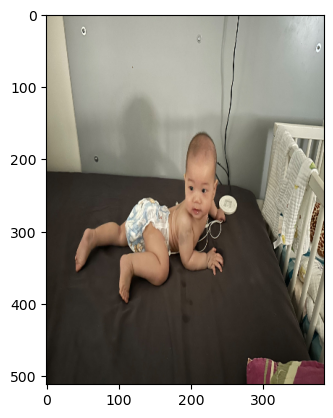

In [3]:
demoer = Demoer()
demoer._make_model(smpl)
demoer.model.eval()

output_folder = '../ut/test_new_render'
img_path = 'data/peiran/images/1.jpg'
# prepare input image
original_img = cv2.imread(img_path, cv2.IMREAD_COLOR | cv2.IMREAD_IGNORE_ORIENTATION)
input_img = cv2.resize(original_img, (cfg.input_img_shape[1], cfg.input_img_shape[0]), interpolation = cv2.INTER_LINEAR)
vis_mesh2 = input_img.copy()
vis_kpts2 = input_img.copy()

fig, ax = plt.subplots()
ax.imshow(input_img[:,:,::-1])
plt.show()






In [4]:

transform = transforms.ToTensor()
img = transform(input_img.astype(np.float32))/255
img = img.cuda()[None,:,:,:]
inputs = {'img': img}
targets = {}
meta_info = {}

with torch.no_grad():
    out = demoer.model(inputs, targets, meta_info, 'test')

mesh = out['smplx_mesh_cam'][0]
points = out['joint_cam_tr'][0, ...]
    


/home/x_hensh/.local/lib/python3.10/site-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3190.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


(256, 192)
(512, 384)


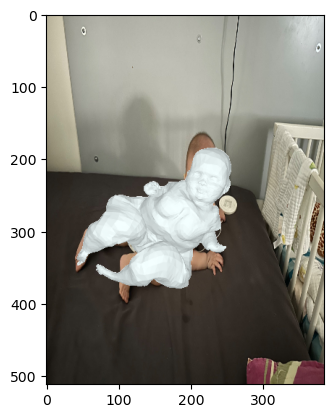

In [5]:
#save_obj(mesh.detach().cpu().numpy(), smpl.face, f'./person.obj') 

print (cfg.input_body_shape)
print (cfg.input_img_shape)

focal = [
    cfg.focal[0] / cfg.input_body_shape[1] * cfg.input_img_shape[1], 
    cfg.focal[1] / cfg.input_body_shape[0] * cfg.input_img_shape[0]
]

princpt = [
    cfg.princpt[0] / cfg.input_body_shape[1] * cfg.input_img_shape[1], # / cfg.input_body_shape[1], 
    cfg.princpt[1] / cfg.input_body_shape[0] * cfg.input_img_shape[0]# / cfg.input_body_shape[0]
]

vis_mesh2 = render_mesh(vis_mesh2, mesh.cpu(), smpl.face, {'focal': focal, 'princpt': princpt})


fig, ax = plt.subplots()
ax.imshow(vis_mesh2[:,:,::-1].astype('uint8'))
plt.show()



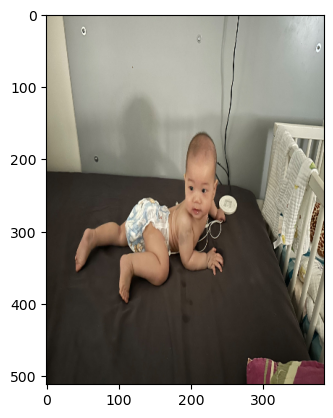

In [6]:

joint_proj = out['smplx_joint_proj'].detach().cpu().numpy()[0]
joint_proj[:, 0] = joint_proj[:, 0] / cfg.output_hm_shape[2] * cfg.input_img_shape[1]
joint_proj[:, 1] = joint_proj[:, 1] / cfg.output_hm_shape[1] * cfg.input_img_shape[0]
joint_proj = np.concatenate((joint_proj, np.ones_like(joint_proj[:, :1])), 1)
#joint_proj = np.dot(bb2img_trans, joint_proj.transpose(1, 0)).transpose(1, 0)
vis_kpts2 = vis_keypoints(vis_kpts2, joint_proj)

    
fig, ax = plt.subplots()
ax.imshow(vis_kpts2[:,:,::-1].astype('uint8'))
plt.show()

In [7]:
print (cfg.input_img_shape)

(512, 384)


torch.Size([1, 512, 384, 4])


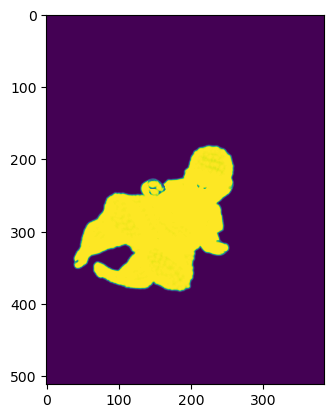

In [8]:
from pytorch3d.structures import Meshes
from pytorch3d.renderer import (
    OpenGLPerspectiveCameras, SoftSilhouetteShader,
    RasterizationSettings, MeshRenderer, MeshRasterizer, BlendParams,PerspectiveCameras, HardPhongShader,PointLights,TexturesVertex
)


device = 'cuda'


focal = [
    cfg.focal[0] / cfg.input_body_shape[1] * cfg.input_img_shape[1], 
    cfg.focal[1] / cfg.input_body_shape[0] * cfg.input_img_shape[0]
]

princpt = [
    cfg.princpt[0] / cfg.input_body_shape[1] * cfg.input_img_shape[1], # / cfg.input_body_shape[1], 
    cfg.princpt[1] / cfg.input_body_shape[0] * cfg.input_img_shape[0]# / cfg.input_body_shape[0]
]

R = torch.tensor(
    [[-1, 0, 0],
     [0, -1, 0],                             
     [0, 0, 1]]).repeat(1, 1, 1).to(device)
T = torch.zeros(3).repeat(1, 1).to(device)


camera_screen = PerspectiveCameras(
    focal_length=[focal,], 
    principal_point=[princpt,], 
    in_ndc=False, 
    image_size=[cfg.input_img_shape,],
    device=device, 
    R=R, 
    T=T)


blend_params = BlendParams(sigma=1e-4, gamma=1e-4)

raster_settings = RasterizationSettings(
            image_size=cfg.input_img_shape,
            blur_radius=np.log(1. / 1e-4 - 1.) * blend_params.sigma,
            faces_per_pixel=100,
            perspective_correct=False,
)

silhouette_renderer = MeshRenderer(
            rasterizer=MeshRasterizer(
                cameras=camera_screen,
                raster_settings=raster_settings
            ),
            shader=SoftSilhouetteShader(blend_params=blend_params)
)


#pdb.set_trace()

torch_mesh = Meshes(verts=mesh.unsqueeze(0).to(device),
                    faces=torch.from_numpy(smpl.face.astype('int')).unsqueeze(0).to(device))
        
silhouette = silhouette_renderer(meshes_world=torch_mesh.clone(), R=R, T=T)#[..., -1]
#screen_size = torch.ones(1, 2) * torch.Tensor(self.size) #torch.ones(vertices.shape[0],2)
#screen_size = screen_size.to(self.device)#torch.ones(1, 2).to(self.device) * self.size #torch.ones(vertices.shape[0],2)

#print (silhuette)

print (silhouette.shape)
silhouette = silhouette[0, :, :, 3]
fig, ax = plt.subplots()
ax.imshow(silhouette.cpu().numpy())
plt.show()

#print (set(silhouette[0, :,:,3].reshape([-1])))


In [ ]:
#print (np.multiply(input_img, 1 - np.expand_dims(silhouette[0, :,:,3].cpu().numpy(), -1)) )
#input_img = np.multiply(input_img, 1 - np.expand_dims(silhouette[0, :,:,3].cpu().numpy(), -1))
rendered =np.multiply(input_img, 1 - np.expand_dims(silhouette.cpu().numpy(), -1)) + np.expand_dims(silhouette.cpu().numpy(), -1)

fig, ax = plt.subplots(1,2, figsize=(15, 9))
ax[0].imshow(rendered.astype('uint8')[:,:,::-1])
ax[1].imshow(vis_mesh2[:,:,::-1].astype('uint8'))
plt.show()

In [ ]:
screen_size = torch.ones(1, 2) * torch.Tensor(torch.Tensor(cfg.input_img_shape)) #torch.ones(vertices.shape[0],2)
screen_size = screen_size.to(device)#torch.ones(1, 2).to(self.device) * self.size #torch.ones(vertices.shape[0],2)


proj_points = camera_screen.transform_points_screen(points.cpu().unsqueeze(0).to(device), image_size=screen_size)[0, :, :2]
print (proj_points)

vis_mesh2 = vis_keypoints(vis_mesh2, proj_points.cpu().numpy())

fig, ax = plt.subplots()
ax.imshow(vis_mesh2[:,:,::-1].astype('uint8'))
plt.show()